In [ ]:
from google.colab import drive
drive.mount(r"/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df= pd.read_csv("/content/gdrive/My Drive/QuoraData/train.csv")

In [ ]:
#number of data points
df.shape[0]

404290

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


there are two missing rows in "question2", we will remove those rows

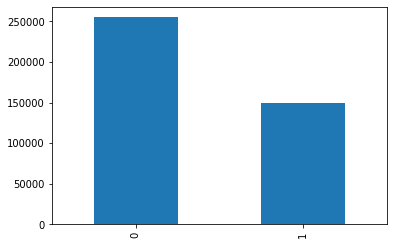

In [ ]:
#getting the distribution of data acrooss is_duplicate column
df["is_duplicate"].value_counts().plot.bar()

In [ ]:
#percentage split
print(' Question pairs are not Similar (is_duplicate = 0):\n   {}% '.format(df["is_duplicate"].value_counts()[0]/df["is_duplicate"].value_counts().sum() *100))
print(' Question pairs which are  Similar (is_duplicate = 1):\n   {}% '.format(100-(df["is_duplicate"].value_counts()[0]/df["is_duplicate"].value_counts().sum() *100)))

 Question pairs are not Similar (is_duplicate = 0):
   63.08021469737069% 
 Question pairs which are  Similar (is_duplicate = 1):
   36.91978530262931% 


In [ ]:
#next, we will find out the unique questions in the data corpus
#we will find this using the ids and converting them into a commmon series
qids = pd.Series(df["qid1"].tolist()+df["qid2"].tolist())
print(qids[:5])
unique_qs = len(np.unique(qids))
#qids.value_counts() > 1 returns binary array and sum wil add up the values having true
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 
q_vals=qids.value_counts()

0    1
1    3
2    5
3    7
4    9
dtype: int64
Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



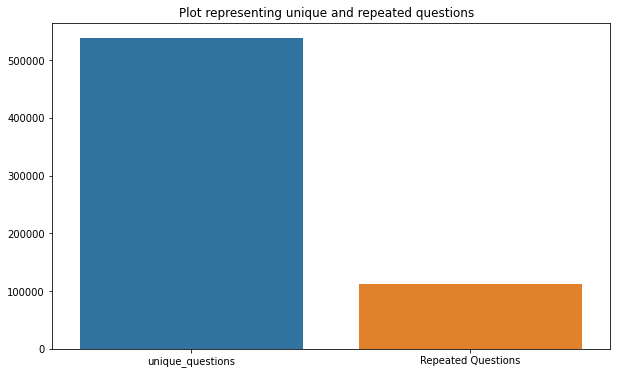

In [ ]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [ ]:
#checking whether there are any duplicates as in same (qid1,qid2) pairs
df.duplicated(["qid1","qid2"]).sum()

0

Text(0, 0.5, 'Number of questions')

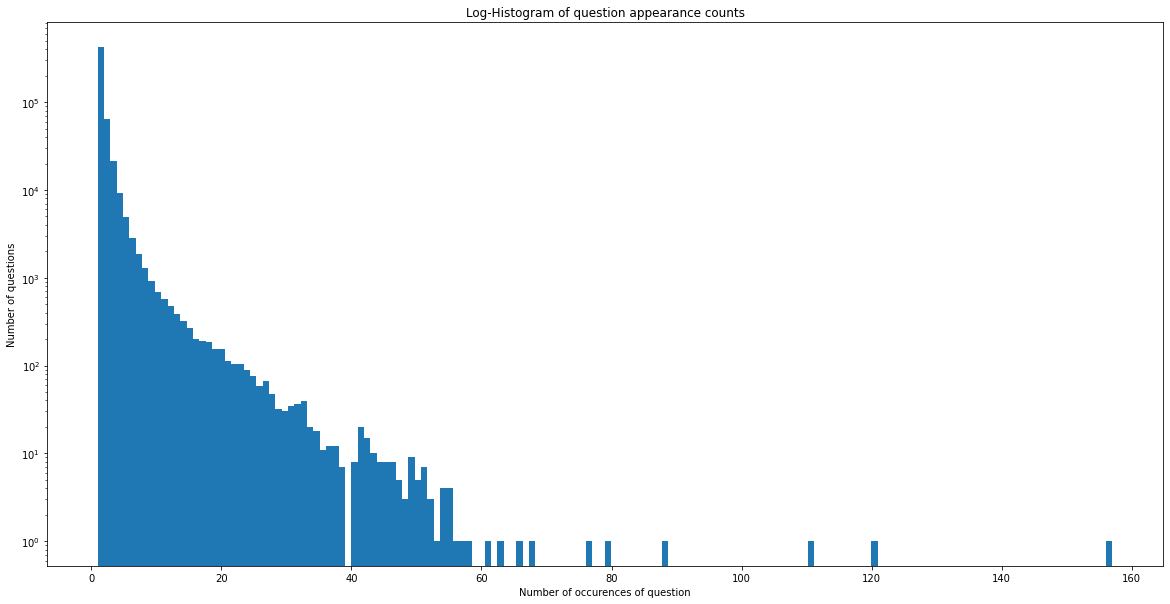

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins=160)
plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')
#max number of questions are unique questions, there are some questions which appear a lot of times

In [ ]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
#we will drop the null values
df =df.dropna()
df.shape[0]

404287

we'll do some basic feature extraction and create some features, we think are important

freq_qid1 = Frequency of qid1's

freq_qid2 = Frequency of qid2's

q1len = Length of q1

q2len = Length of q2

q1_n_words = Number of words in Question 1

q2_n_words = Number of words in Question 2

word_Common = (Number of common unique words in Question 1 and Question 2)

word_Total =(Total num of words in Question 1 + Total num of words in Question 2)

word_share = (word_common)/(word_Total)

freq_q1+freq_q2 = sum total of frequency of qid1 and qid2

freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2


In [ ]:
import os
if os.path.isfile("df_fe_without_preprocessing_train.csv"):
  df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
  df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
  df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
  df['q1len'] = df['question1'].str.len() 
  df['q2len'] = df['question2'].str.len()
  df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
  df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

#we will find the common unique words using sets concept
  def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
  df['word_Common'] = df.apply(normalized_word_Common, axis=1)
#finding the total unique words in question1 and question2
  def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
  df['word_Total'] = df.apply(normalized_word_Total, axis=1)
#finding the word share 
  def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
  df['word_share'] = df.apply(normalized_word_share, axis=1)

  df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
  df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
  df.to_csv("df_fe_without_preprocessing_train.csv", index=False)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


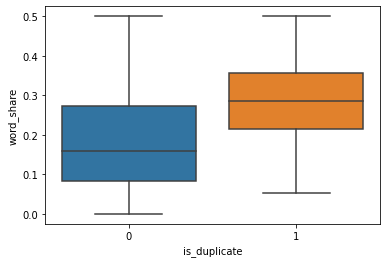

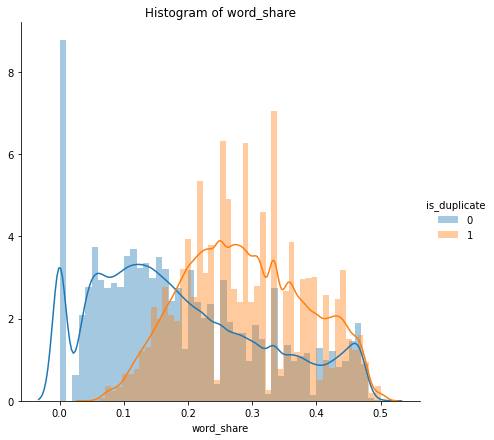

In [ ]:
#using our newly created feature wrd_share for univariate analysis
sns.boxplot(x = 'is_duplicate', y = 'word_share', data = df)
sns.FacetGrid(df, hue="is_duplicate",size=6)\
   .map(sns.distplot,"word_share")\
   .add_legend()
plt.title("Histogram of word_share")
plt.show()
plt.show()

from the graph, we could see that the word_share feature though it is not perfectly separating, it has some significance

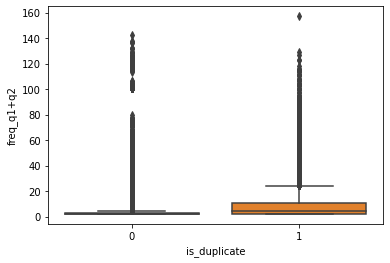

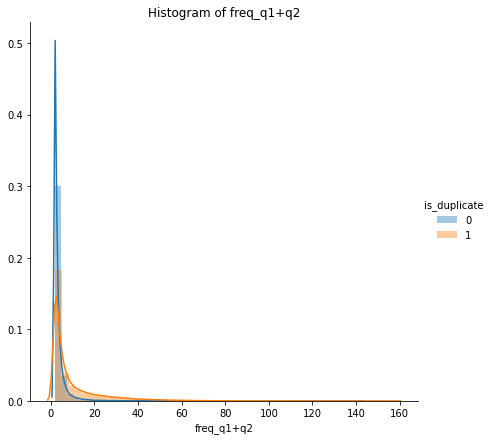

In [ ]:
#using our newly created feature wrd_share for univariate analysis
sns.boxplot(x = 'is_duplicate', y = 'freq_q1+q2', data = df)
sns.FacetGrid(df, hue="is_duplicate",size=6)\
   .map(sns.distplot,"freq_q1+q2")\
   .add_legend()
plt.title("Histogram of freq_q1+q2")
plt.show()
plt.show()

this feature is not useful

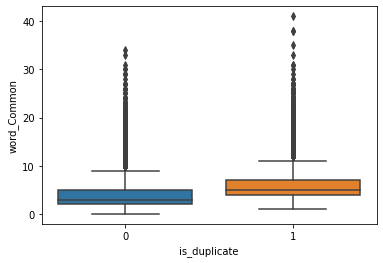

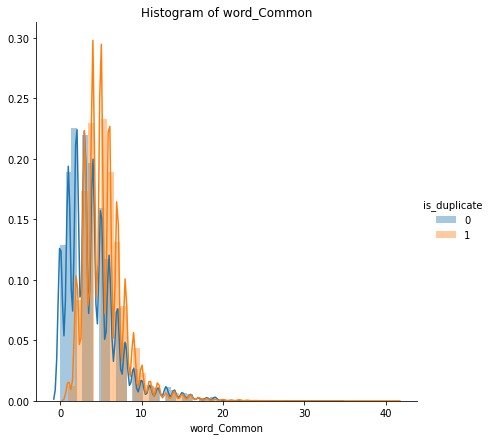

In [ ]:
#using our newly created feature wrd_share for univariate analysis
sns.boxplot(x = 'is_duplicate', y = 'word_Common', data = df)
sns.FacetGrid(df, hue="is_duplicate",size=6)\
   .map(sns.distplot,"word_Common")\
   .add_legend()
plt.title("Histogram of word_Common")
plt.show()
plt.show()

this feature can be moderately useful but The distributions of the word_Common feature in similar and non-similar questions are highly overlapping

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("file not present")

In [ ]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [ ]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 
STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)

    #stemming
    porter = PorterStemmer()
    #replacing all sepcial characters
    pattern = re.compile('\W')
    
    #if condition to check if its a string or not
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
    return x

cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
cwc_min = common_word_count / (min(len(q1_words), len(q2_words))



cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
cwc_max = common_word_count / (max(len(q1_words), len(q2_words))



csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))



csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))



ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))



ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))



last_word_eq : Check if First word of both questions is equal or not
last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])



first_word_eq : Check if First word of both questions is equal or not
first_word_eq = int(q1_tokens[0] == q2_tokens[0])



abs_len_diff : Abs. length difference
abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))



mean_len : Average Token Length of both Questions
mean_len = (len(q1_tokens) + len(q2_tokens))/2

fuzz_ratio

fuzz_partial_ratio 

token_sort_ratio

token_set_ratio 

longest_substr_ratio 

longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))



In [ ]:
pip install fuzzywuzzy

In [ ]:
pip install distance


     |████████████████████████████████| 184kB 5.2MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp37-none-any.whl size=16275 sha256=54fd2caccf0321af110d74072ff4a12c789db54f7acc200a6b742f57cc07954b
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


In [ ]:
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# This package is used for finding longest common subsequence between two strings
import distance

In [ ]:
#getting tokens from sentences and converting them to our designed features

def get_token_features(q1,q2):
  token_features = [0.0]*10

  #converting sentence into tokens
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens)==0 or len(q2_tokens)==0:
    return token_features
  
  #get the non-stop words in Questions by using set properties
  q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
  q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

  #get the stopwords in Questions
  q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
  q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

  #common non-stopwords in Question pair
  common_word_count = len(q1_words.intersection(q2_words))

  # Get the common stopwords from Question pair
  common_stop_count = len(q1_stops.intersection(q2_stops))
    
  # Get the common Tokens from Question pair
  common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

  token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
  token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
  token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
  token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
  token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
  token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

  # Last word of both question is same or not
  token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
  # First word of both question is same or not
  token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
  token_features[8] = abs(len(q1_tokens) - len(q2_tokens))

  #Average Token Length of both Questions
  token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
  return token_features

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

#now we pass the data for feature extraction
def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))

    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [ ]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("/content/gdrive/My Drive/QuoraData/nlp_features_train.csv",encoding='latin-1')
else:
    print("Extracting features for train:")
    df= pd.read_csv("/content/gdrive/My Drive/QuoraData/train.csv")
    df = pd.read_csv("/content/gdrive/My Drive/QuoraData/nlp_features_train.csv",encoding='latin-1')
    #df = extract_features(df)
    #df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [ ]:
#before we analyze the features and their importance,let's plot the word clouds of the words
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [ ]:
import os
from os import path

In [ ]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
#removing "not", "like", "no" as they might add some semantic meaning to the sentence
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193130


In [ ]:
pip install WordCloud

In [ ]:
from wordcloud import WordCloud

Word Cloud for Duplicate Question pairs


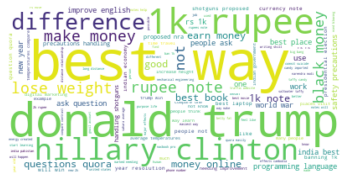

<Figure size 576x432 with 0 Axes>

In [ ]:
wc = WordCloud(background_color="white",max_words=len(textp_w),stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(8,6))
plt.show()

Word Cloud for non-Duplicate Question pairs:


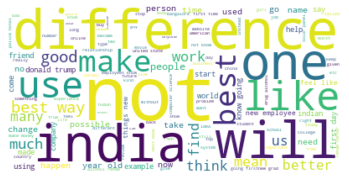

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

the word clouds show that the words are not similar in positive and negative classes

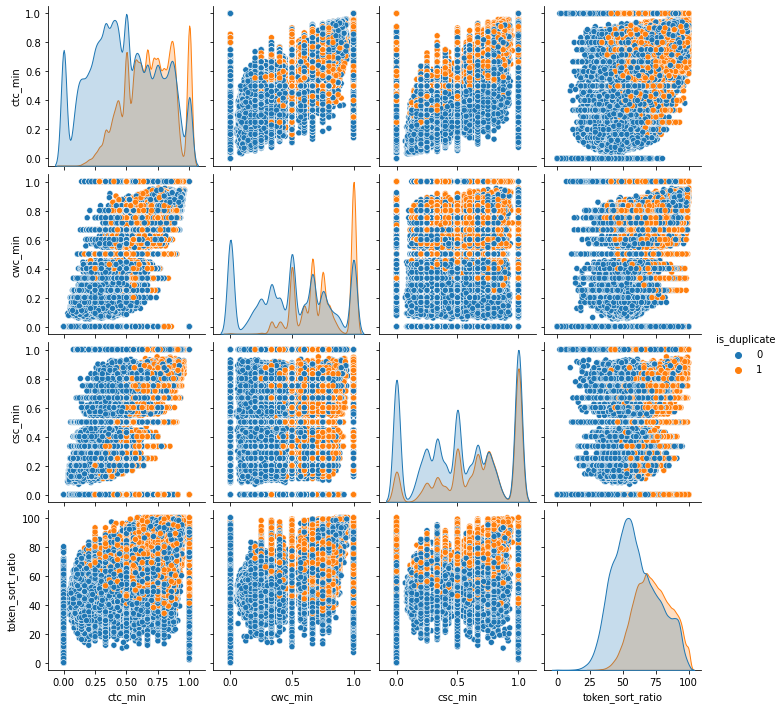

In [ ]:
#bivariate analysis using pairplot
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

if we see the PDFs, then the we see that although the features are overalapping, there are some regions in all the features where clear blue and red zones are demarked and this is a very healthy sign and so, we can say that our features are making some sense

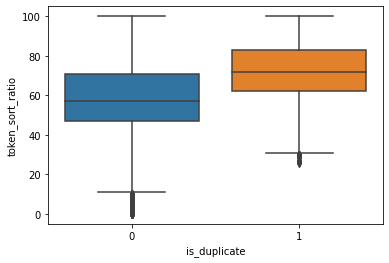

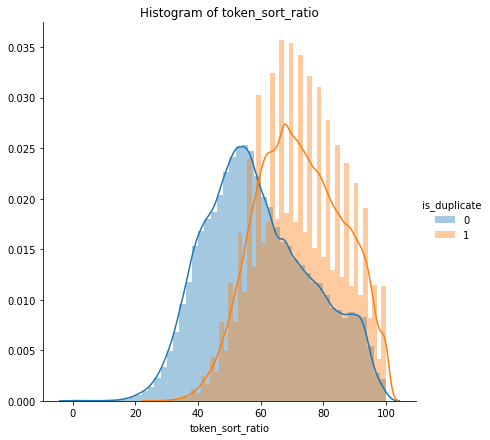

In [ ]:
# Distribution of the token_sort_ratio
sns.boxplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df)
sns.FacetGrid(df, hue="is_duplicate",size=6)\
   .map(sns.distplot,"token_sort_ratio")\
   .add_legend()
plt.title("Histogram of token_sort_ratio")
plt.show()
plt.show()

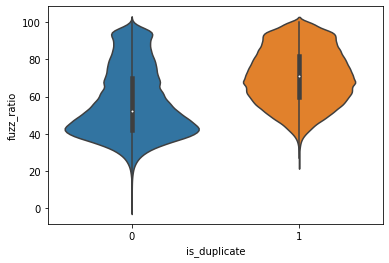

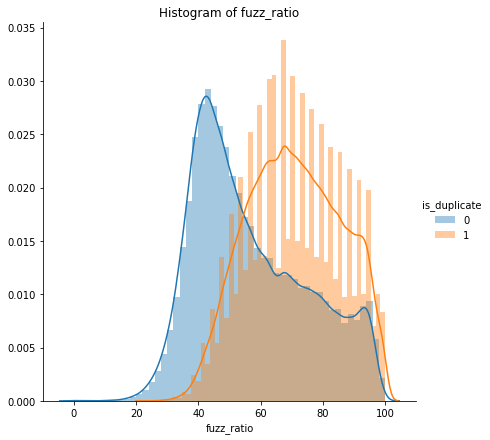

In [ ]:
#for fuzz ratio
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )
sns.FacetGrid(df, hue="is_duplicate",size=6)\
   .map(sns.distplot,"fuzz_ratio")\
   .add_legend()
plt.title("Histogram of fuzz_ratio")
plt.show()
plt.show()

In [ ]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 2 dimensions

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:10000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [ ]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=3000,
    verbose=2,
    angle=0.5,
    perplexity=50
).fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.044s...
[t-SNE] Computed neighbors for 10000 samples in 1.506s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.109601
[t-SNE] Computed conditional probabilities in 1.044s
[t-SNE] Iteration 50: error = 88.9967117, gradient norm = 0.0246857 (50 iterations in 5.680s)
[t-SNE] I

In [ ]:
tsne2d.shape

(10000, 2)

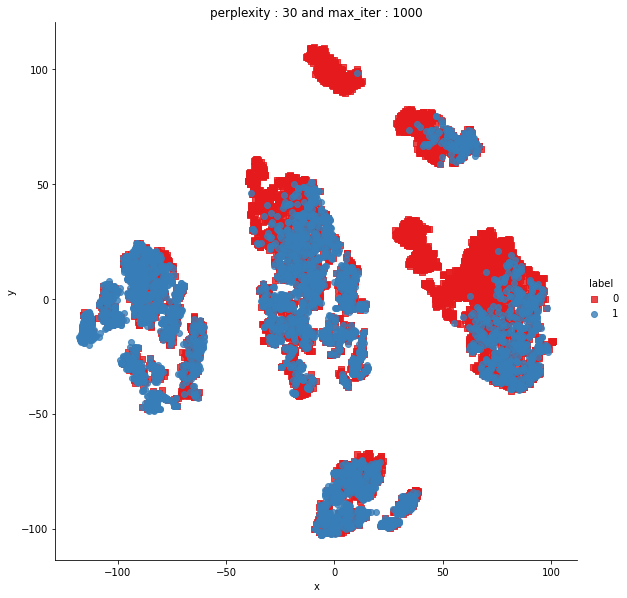

In [ ]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#for glove vector (which is similar to word2Vec) and is trained on wiki 

In [ ]:
pip install spacy

In [ ]:
import spacy

In [ ]:
#to avoid decoding issues
df= pd.read_csv("/content/gdrive/My Drive/QuoraData/train.csv")
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
df_s =df[:5000]

In [ ]:
#merge texts
questions = list(df_s['question1']) + list(df_s['question2'])
tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)


<10000x11734 sparse matrix of type '<class 'numpy.float64'>'
	with 101005 stored elements in Compressed Sparse Row format>

In [ ]:
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
word2tfidf.items()

dict_items([('000', 7.074946151047366), ('04', 9.517293186416572), ('07904378172', 9.517293186416572), ('09', 9.517293186416572), ('10', 6.203107181744045), ('100', 7.571383037361257), ('1000', 5.656563475375975), ('10000', 9.517293186416572), ('1000rs', 9.517293186416572), ('100mg', 9.517293186416572), ('103', 9.517293186416572), ('1042s', 9.517293186416572), ('107', 9.111828078308406), ('108', 9.111828078308406), ('1080', 9.517293186416572), ('1080p', 9.517293186416572), ('109', 9.517293186416572), ('10K', 9.517293186416572), ('10k', 8.824146005856626), ('10th', 8.41868089774846), ('11', 7.502390165874306), ('114', 9.517293186416572), ('11th', 8.41868089774846), ('11years', 9.517293186416572), ('12', 6.991564542108315), ('120', 9.517293186416572), ('125', 9.517293186416572), ('12th', 7.812545094178145), ('13', 7.725533717188516), ('130', 9.517293186416572), ('1300D', 9.517293186416572), ('138', 9.111828078308406), ('14', 7.437851644736734), ('14159265359', 9.517293186416572), ('143',

In [ ]:
#After we find TF-IDF scores, we convert each question to a 
#weighted average of word2vec vectors by these scores.
#here we use a pre-trained GLOVE model which comes free with "Spacy
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')
vecs1 = []
for qu1 in list(df_s['question1']):
  doc1 = nlp(qu1) 
  # 96 is the number of dimensions of vectors 
  mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
  for word1 in doc1:
    # word2vec
    vec1 = word1.vector
    # fetch df score
    try:
      idf = word2tfidf[str(word1)]
    except:
      idf = 0
    # compute final vec
    mean_vec1 += vec1 * idf
  mean_vec1 = mean_vec1.mean(axis=0)
  vecs1.append(mean_vec1)
df_s['q1_feats_m'] = list(vecs1) 

In [ ]:
doc1 = nlp(df['question1'][0]) 
doc1.vector

array([-0.16589771,  0.32478327, -0.6653689 ,  0.1354071 ,  1.9162713 ,
        1.3345809 ,  0.9940088 ,  0.4489258 ,  0.49800268,  2.6125793 ,
        0.31170452, -0.4681784 , -0.62482643, -0.6834919 , -0.2708781 ,
       -1.1121689 , -0.23760809, -0.8154266 , -0.5048095 , -0.08899816,
        0.64615285,  0.80273604,  0.32758227,  0.2549642 , -0.8127078 ,
       -0.27464503,  0.35430452,  0.28192022,  0.8141919 , -1.2172989 ,
        1.284598  , -0.53818774,  0.2456831 , -0.63651454, -0.624349  ,
       -0.7674658 ,  1.6321125 , -0.53860986,  0.0304248 , -0.95677185,
        1.5244955 ,  0.5088553 , -0.5624766 , -2.709468  ,  0.33534902,
       -0.19840352,  1.4956894 , -1.2570714 , -1.8274422 ,  0.84375215,
        1.714018  , -0.48456946, -0.44040585,  0.39786345, -1.7048776 ,
        1.7370867 ,  0.90140575,  0.62971187, -0.37257892,  1.0412742 ,
        0.90715307, -0.33979553,  1.2861196 ,  0.30603403, -0.23168327,
       -0.7879236 ,  0.43202844, -1.1686186 , -0.2464551 ,  0.45

In [ ]:
vecs2 = []
for qu2 in list(df_s['question2']):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df_s['q2_feats_m'] = list(vecs2)

In [ ]:
df_s.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_feats_m,q2_feats_m
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[-8.694059133529663, 38.25235426425934, -65.96...","[-16.503913581371307, 59.714824974536896, -52...."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[9.069696888327599, -60.576460897922516, -38.2...","[0.3271392062306404, -3.6455471515655518, -114..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[96.33729124069214, 21.6694518327713, -37.0384...","[151.17790143191814, 60.940550088882446, -6.73..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[57.882615089416504, -20.722031235694885, -4.3...","[45.54362431168556, 55.55720153450966, 30.3863..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[70.64391243457794, -29.32994830608368, -71.68...","[-16.07863712310791, -3.5132498145103455, -74...."


In [ ]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
dfnlp = pd.read_csv("/content/gdrive/My Drive/QuoraData/nlp_features_train.csv",encoding='latin-1')
dfnlp = dfnlp[:5000]

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    dfppro = dfppro[:5000]
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [ ]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df_s.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
#converting our 96 values to seaprate dataframe
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [ ]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,-8.694059,38.252354,-65.967409,30.949855,137.915632,131.999038,18.897503,54.107262,79.140374,227.913407,26.346915,-7.524619,37.741184,-100.099170,-7.671059,-91.837558,-31.195587,-27.981076,-38.176176,29.896877,63.670799,54.845709,7.486943,19.028678,-55.691309,-39.010055,31.079695,-16.518777,91.327835,-104.853113,130.185718,-66.453452,55.794429,-92.040080,-35.168234,-85.427967,194.283465,-56.927465,-31.198404,-67.548571,...,111.442027,48.608390,-55.120051,105.815431,96.890326,-66.305603,86.775518,46.178001,-14.298942,-106.036165,75.855150,-74.150389,-52.977589,53.023345,-131.064386,17.723702,-13.663468,-43.407903,-69.610199,64.573184,135.840376,-129.227712,13.083449,11.975349,21.842878,-82.063788,-53.461025,-19.700469,5.882418,-14.058174,-69.963691,-57.656934,-20.337003,100.550044,-67.416798,-53.972731,-67.370102,110.924148,57.347991,-13.222730
1,9.069697,-60.576461,-38.256653,61.020055,152.547446,79.445141,67.373773,38.042629,104.384130,96.731548,58.479875,-35.025140,21.696066,-62.185645,-83.186774,-68.526171,13.471828,55.627942,-3.462732,-45.545208,5.271894,-34.618326,-10.120601,-82.324964,-78.069845,-66.692061,14.989321,-99.327685,42.877948,-99.925962,-16.481074,5.966194,27.948228,-26.550901,46.956668,-114.013762,151.560925,-44.750628,-86.078976,-50.698996,...,54.254908,96.118013,2.887629,-39.617166,-62.250997,-34.401668,2.036960,24.419960,58.559900,43.349247,49.729983,-26.546718,-50.630057,57.686838,-103.939590,0.643890,44.651676,2.193262,-39.348211,-17.873344,123.560157,-20.761547,-37.644849,-15.878898,84.885887,-66.987156,-9.974116,20.476009,7.974800,106.532453,-30.554517,-69.414603,13.293478,-8.404724,-68.827606,60.856026,30.309753,108.043836,94.102345,6.300730
2,96.337291,21.669452,-37.038405,19.043389,56.680003,47.197611,8.783465,36.321422,105.358385,221.865700,-4.967760,-65.924953,-53.020869,-110.660526,47.798898,4.596029,-23.122944,4.234573,-19.500379,-51.398883,58.856998,100.867865,-5.821797,-47.039666,-50.194955,25.537349,-70.871978,-81.766107,59.493735,-58.492046,84.071211,94.239965,-10.240449,-43.982971,-26.418611,-8.931284,64.841334,-83.571361,-132.879994,-57.809294,...,125.403970,32.293279,11.140718,31.627953,125.420155,-115.667182,-51.748044,115.651978,-6.595720,-27.650669,21.820019,-94.351362,-14.272872,66.565306,-19.926203,-0.330344,61.530073,20.812756,-35.012610,6.756171,99.265020,-90.064709,-12.340213,-19.467507,15.328765,9.078338,-75.768666,76.753062,58.522880,-77.564497,-65.071344,85.871801,4.841229,55.464524,-43.096136,-57.514319,-48.918823,77.075908,104.316933,-32.522220
3,57.882615,-20.722031,-4.399092,-87.181831,-3.390423,-51.824725,73.161212,105.392103,14.988592,39.226077,-98.621866,-12.742646,143.709837,98.281166,63.644042,143.529135,-74.215833,-59.283123,-60.582480,7.745722,-31.496599,-6.186970,-27.131559,-32.471407,23.103630,118.690902,4.918684,-108.269958,-10.126021,-23.322757,-37.952215,-17.533414,37.541034,-49.478574,-14.588794,-57.288186,19.653646,-95.456434,-83.296812,18.472570,...,97.123586,21.046538,-17.569212,19.144661,18.779948,-149.942291,-27.015084,2.321590,6.751142,-14.699844,-96.530824,14.441762,68.478027,20.226751,-21.199387,-13.469404,46.354923,29.268155,-5.039285,-100.107998,124.389536,-19.825194,-41.476619,79.573011,36.470840,-84.267118,-23.985117,53.373792,-12.292344,-26.200857,27.646029,41.778324,-8.502269,16.995250,-36.562732,7.996812,-64.265127,92.510092,-33.658145,70.418222
4,70.643912,-29.329948,-71.685274,-49.793260,72.398709,-20.244681,48.386151,77.811979,137.381971,259.624081,41.420813,26.351471,144.130404,-71.611539,50.251816,42.140949,-71.685538,-32.567499,-47.367301,-40.393320,110.125436,8.593925,-50.398150,-14.918690,-80.608865,16.205299,-0.814845,-141.892002,142.003111,-78.513971,67.541802,74.646037,47.014810,-50.209482,-18.764748,-7

In [ ]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [ ]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
from google.colab import drive
drive.mount(r"/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import sqlite3
#connecting the SQLite table to read data
con = sqlite3.connect('/content/gdrive/My Drive/QuoraData/train.db')

In [ ]:
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [ ]:
read_db = 'train.db'
checkTableExists(con)
con.close()

Tables in the databse:
data


In [ ]:
# try to sample data according to the computing power you have
conn_r = sqlite3.connect('/content/gdrive/My Drive/QuoraData/train.db')
if conn_r is not None:
  # for selecting first 1M rows
  # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
  # for selecting random points
  data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 10001;", conn_r)
  conn_r.commit()
  conn_r.close()   

In [ ]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [ ]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.33332222259258,0.33332222259258,0.999975000624984,0.799984000319994,0.714275510349852,0.624992187597655,1.0,1.0,1.0,7.5,82,82,82,81,0.3125,1,1,31,32,7,8,5.0,15.0,0.333333333333333,2,0,5.78974181413651,-8.90608429908752,21.6474866569042,38.102189540863,9.08404052257538,-6.13277232646942,-30.4669914245606,-12.7419176101685,14.3933153152466,-6.69291090965271,20.2441404461861,-13.0061228275299,43.6495715379715,-9.7713528200984,...,-4.43894056417048,-5.52655081450939,-5.18150529265404,12.6724581867456,14.4717753976583,-1.97438638284802,-9.5337696550414,6.96132436394692,-5.18747562170029,-1.43674187362194,-0.436001420021057,-0.0604050010442734,-6.98194715380669,-0.293421021662652,0.455043375492096,-11.1234133541584,-4.58954465389252,2.80194720625877,4.86075107939541,6.19232315197587,-16.1379366517067,-9.91933256387711,-6.3322022780776,-8.25452324002981,6.52555020898581,14.8723518848419,-10.7774459123611,2.82151775248349,-3.07756961882114,-5.62422835826874,10.4425162151456,2.17415662109852,-4.80236604064703,-5.86298959178384,7.35304823517799,10.3379238024354,-5.80348394438624,5.60598650574684,9.77500641345978,4.04124177247286
2,0.833319444675922,0.714275510349852,0.999966667777741,0.599988000239995,0.888879012455417,0.666661111157407,0.0,1.0,3.0,10.5,98,79,77,76,0.441860465116279,1,1,42,61,9,12,7.0,21.0,0.333333333333333,2,0,26.7738084793091,58.4492635726929,46.4944964945316,59.81585085392,-27.0905039310455,10.9397644996643,-37.834241271019,-68.60373878479,51.8214199542999,-14.2237721681595,-59.4610707163811,26.7759382724762,-12.5640022754669,-15.5363963842392,...,-25.7603839486837,7.4510917365551,-2.73630054295063,11.8715986495372,26.4357407093048,-8.33594767376781,-5.82402294455096,19.0012399032712,-16.1900486350059,10.9938502013683,11.7490528225899,-1.32946899905801,11.1857760474086,-16.8842435817933,-9.09629014134407,-14.4395827054977,-23.6566670387983,-1.75742799043655,9.95481632649898,-4.26162503659725,-26.63884575665,-10.5128477811813,14.7791744023561,8.58572925627232,9.69627559185028,28.676388412714,-12.5376490801573,13.9749178509228,-9.19430916476995,0.736032381653786,8.53926631435752,4.15418255329132,8.09402360022068,-3.39424445061013,9.72896602749824,2.30124694108963,-8.33329641819,2.95589616894722,11.6391094438732,0.158311754930764
3,0.285710204139941,0.285710204139941,0.199996000079998,0.199996000079998,0.249997916684028,0.230767455634957,0.0,0.0,1.0,12.5,56,56,47,53,0.222222222222222,1,1,75,62,13,12,2.0,24.0,0.0833333333333333,2,0,-46.4183820486069,116.094159841537,138.523315653205,108.1351865381,-43.4856219291687,28.4448778629303,-104.696087360382,-105.700097799301,-7.56710082292557,-49.3100380897522,-54.3480951339006,14.711492061615,31.0527169406414,-144.415712356567,...,-19.2987524420023,-1.06610655784607,-9.43924480676651,26.5819946527481,26.0061751119792,11.8356432914734,-2.13978509604931,20.710974663496,-7.1059982329607,-11.8155073523521,20.6194813251495,-26.2880655378103,2.80437113344669,-27.2827126905322,-1.51179727166891,-28.0022447705269,-20.1739493906498,3.48760166764259,12.8286306811497,-1.92361183464527,-32.1933705471456,-10.8358667381108,2.20384678244591,-18.2044980451465,9.86453200131655,30.3740205541253,-15.442046046257,24.3847589492798,-17.7475508749485,16.3276277333498,-0.418711724225432,18.2714613080025,15.5236286818981,-7.35823950171471,-0.241001419723034,-2.50443702936173,2.96796044334769,10.2406899631023,14.14

In [ ]:
cols = list(data.columns)
data = pd.DataFrame(np.array(data.values,dtype=np.float64),columns=cols)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136

In [ ]:
y_true = list(map(int, y_true.values))


In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

In [ ]:
#random split
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3,random_state=42)

In [ ]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (7000, 794)
Number of data points in test data : (3000, 794)


In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6281428571428571 Class 1:  0.37185714285714283
---------- Distribution of output variable in test data ----------
Class 0:  0.6283333333333333 Class 1:  0.37166666666666665


the distribution is almost same as we stratified the data split

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    B =(C/C.sum(axis=0))
    #divide each element of the confusion matrix with the sum of elements in that row
    plt.figure(figsize=(20,4))
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()


In [ ]:
from sklearn.metrics.classification import accuracy_score, log_loss

Log loss on Test Data using Random Model 0.8971620831935704


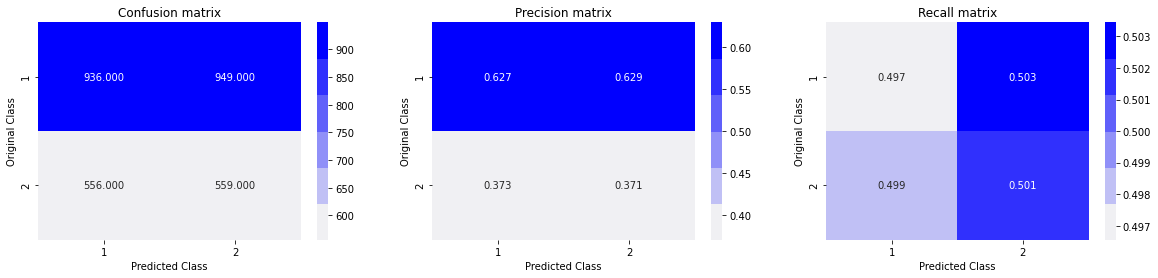

In [ ]:
#building a random model
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

we can see that the random function log-loss is 0.88 and our model should be ideally in the range of [0,0.88) 
the precision and recall values should also be higher than the random model

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.659837052285378
For values of alpha =  0.0001 The log loss is: 0.659837052285378
For values of alpha =  0.001 The log loss is: 0.5084638790185304
For values of alpha =  0.01 The log loss is: 0.5096872762918122
For values of alpha =  0.1 The log loss is: 0.5053235602915552
For values of alpha =  1 The log loss is: 0.5117158150333112
For values of alpha =  10 The log loss is: 0.521479507757287


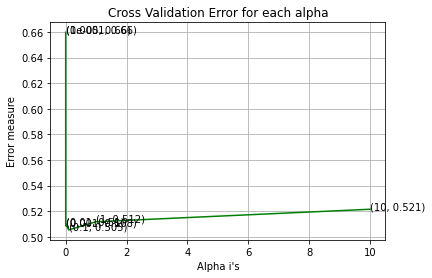

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.1, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                             

For values of best alpha =  0.1 The train log loss is: 0.4573885824391911
For values of best alpha =  0.1 The test log loss is: 0.5053235602915552
Total number of data points : 3000


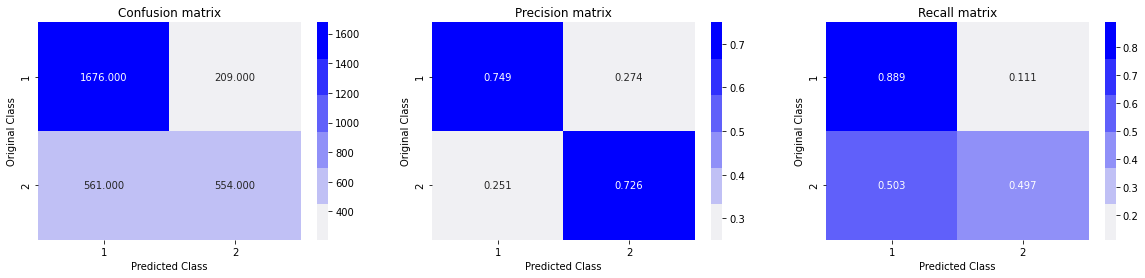

In [ ]:
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

train loss and test loss is not very far away, hence the model is not overfitting, but it might have a underfit problem as random model itself is 0.88, we have space to improve

we can see that the precision and recall of class 1 has imporved
but the concer is the recall of class 2, which is very low

In [ ]:
#using SVM classifier, the loss will be hinge
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 0.659837052285378
For values of alpha =  0.0001 The log loss is: 0.659837052285378
For values of alpha =  0.001 The log loss is: 0.659837052285378
For values of alpha =  0.01 The log loss is: 0.659837052285378
For values of alpha =  0.1 The log loss is: 0.659837052285378
For values of alpha =  1 The log loss is: 0.659837052285378
For values of alpha =  10 The log loss is: 0.659837052285378


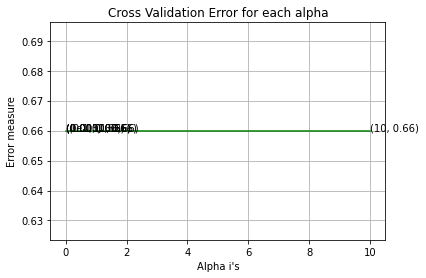

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [ ]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l1',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                         

For values of best alpha =  1e-05 The train log loss is: 0.6599367618737666
For values of best alpha =  1e-05 The test log loss is: 0.659837052285378
Total number of data points : 3000


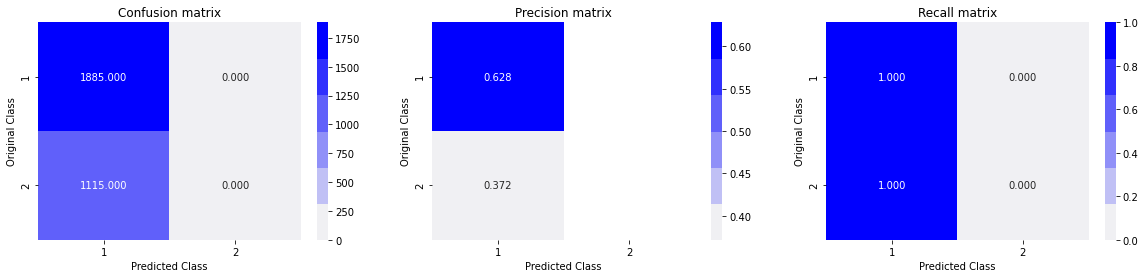

In [ ]:
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
#XGBoost
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
#eta is learning rate
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)
#watchlist is for logging
watchlist = [(d_train, 'train'), (d_test, 'valid')]
#400 is the number of iteration
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684713	valid-logloss:0.685128
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.615575	valid-logloss:0.619372
[20]	train-logloss:0.565393	valid-logloss:0.572201
[30]	train-logloss:0.527009	valid-logloss:0.536515
[40]	train-logloss:0.496836	valid-logloss:0.50806
[50]	train-logloss:0.472093	valid-logloss:0.48496
[60]	train-logloss:0.4528	valid-logloss:0.466713
[70]	train-logloss:0.435939	valid-logloss:0.45087
[80]	train-logloss:0.422341	valid-logloss:0.439238
[90]	train-logloss:0.410892	valid-logloss:0.429155
[100]	train-logloss:0.401396	valid-logloss:0.420994
[110]	train-logloss:0.393391	valid-logloss:0.41438
[120]	train-logloss:0.386624	valid-logloss:0.408834
[130]	train-logloss:0.380707	valid-logloss:0.404325
[140]	train-logloss:0.375391	valid-logloss:0.400647
[150]	train-logloss:0.370391	valid-logloss:0.397684
[160]	train-logloss:0.365598	valid

In [ ]:
from scipy.stats import randint as sp_randint
from random import uniform
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from xgboost import XGBClassifier

In [ ]:
n_estimators = [100, 300, 500, 700, 900, 1100, 1300, 1500]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
colsample_bytree = [0.1, 0.3, 0.5, 0.7 , 0.9, 1]
subsample = [0.1,0.3,0.5,0.7,0.9,1]

In [ ]:
def hyperparameter_tuning(X,Y):
    param_grid = dict(learning_rate=learning_rate,
                      n_estimators=n_estimators,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample)
    print("started")
    model = XGBClassifier(nthread=-1)
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    random_search = RandomizedSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    random_result = random_search.fit(X,Y)
    print("end")
    # Summarize results
    print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
    print()
    means = random_result.cv_results_['mean_test_score']
    stds = random_result.cv_results_['std_test_score']
    params = random_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    return random_result

In [ ]:
param_grid = dict(learning_rate=learning_rate,
                      n_estimators=n_estimators,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample)
print("started")
model = XGBClassifier(nthread=-1)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
random_search = RandomizedSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
random_result = random_search.fit(X_train,y_train)
print("end")
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
print()
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

started
